In [41]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
print("Loading Water_potability_data_glug_glug....")
df = pd.read_excel("../water_potability_master_clean.xlsx", engine="openpyxl")
X = df.drop("Potability", axis=1).values
y = df["Potability"].values

print("Splitting For Training...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Splitting for validation...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Loading Water_potability_data_glug_glug....
Splitting For Training...
Splitting for validation...


In [43]:
potability_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

# Some class weights due to being the dataset imbalanced
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print("\n Class Weight:", class_weight_dict)


potability_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy', keras.metrics.AUC(name="auc")]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True

)

print("\n Training Model ...")

good_potability = potability_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    # class_weight=class_weight_dict,
    verbose=1
)

print("\n Evaluating Model")
potability_model.evaluate(X_test, y_test)


 Class Weight: {0: np.float64(0.8200312989045383), 1: np.float64(1.2811735941320292)}

 Training Model ...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5802 - auc: 0.4914 - loss: 0.6959 - val_accuracy: 0.6145 - val_auc: 0.5243 - val_loss: 0.6702
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6088 - auc: 0.5374 - loss: 0.6695 - val_accuracy: 0.6412 - val_auc: 0.5901 - val_loss: 0.6567
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - auc: 0.5877 - loss: 0.6581 - val_accuracy: 0.6584 - val_auc: 0.6260 - val_loss: 0.6465
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6398 - auc: 0.6105 - loss: 0.6481 - val_accuracy: 0.6622 - val_auc: 0.6554 - val_loss: 0.6362
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - auc: 0.6190 - loss: 0.6458 - val_accuracy: 0.6641 - val_auc: 0.6700 - val_loss: 0.6289
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - auc: 0.6476 - loss: 0.634

[0.6344407200813293, 0.6661585569381714, 0.6477978229522705]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
 [[351  49]
 [170  86]]
              precision    recall  f1-score   support

 Not Potable       0.67      0.88      0.76       400
     Potable       0.64      0.34      0.44       256

    accuracy                           0.67       656
   macro avg       0.66      0.61      0.60       656
weighted avg       0.66      0.67      0.64       656



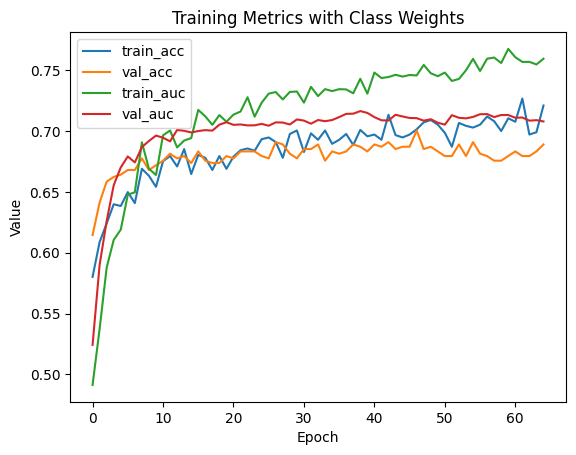

In [44]:
# Plot Validation loss and Training loss
def plot_loss(history):

    # Accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')

    # AUC
    plt.plot(history.history['auc'], label='train_auc')
    plt.plot(history.history['val_auc'], label='val_auc')

    plt.title('Training Metrics with Class Weights')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Predict probabilities → convert to 0/1
y_pred = (potability_model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=['Not Potable', 'Potable'])
print(report)    

plot_loss(good_potability)